# HOUSE PRICE PREDICTION
This project predicts house prices using Linear Regression.


Importing the data from kaggle{ https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data }

In [2]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(train_df.shape)
train_df.head()


(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Figuring out which columns are useless and null

In [3]:
train_df.info()
train_df.isnull().sum().sort_values(ascending=False).head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
dtype: int64

### 🧹 Data Preprocessing Function: `preprocess()`

This function is responsible for **cleaning and preparing the dataset** for machine learning. It takes in the training and test dataframes and performs the following steps:

---

#### 🔻 Step 1: Drop Irrelevant or Sparse Columns
Certain columns like `PoolQC`, `MiscFeature`, `Alley`, `Fence`, and `FireplaceQu` are dropped because they have too many missing values or are not useful for prediction.

```python
cols_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']

```
#### Step 2: Handle Missing Numerical Data
Missing values in numerical columns such as LotFrontage, GarageYrBlt, and MasVnrArea are filled using the median value.

#### 📊 Step 3: Handle Missing Categorical Data
Categorical columns like MasVnrType, GarageType, etc. are filled with their mode (most frequent value).

#### 🔢 Step 4: Encode Ordinal Features
Ordinal columns (like ExterQual, BsmtQual, etc.) have an inherent order. These are mapped to integers based on quality or condition levels.

Example mapping:

'Ex' → 5 (Excellent)
'Gd' → 4 (Good)
'TA' → 3 (Typical/Average)
'Fa' → 2 (Fair)
'Po' → 1 (Poor)

This helps preserve the ranking information in these features.

#### 🧬 Step 5: Encode Nominal Features
Nominal categorical columns (those without order) are encoded using One-Hot Encoding via pd.get_dummies(), dropping the first level to avoid multicollinearity.

#### 🧮 Step 6: Prepare Final Feature Matrix and Target
Features (X) are created by dropping Id and SalePrice.

Target variable (y) is set as SalePrice.

Finally, the data is split into training and validation sets using train_test_split.

In [4]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split

def preprocess(train_df, test_df):

    cols_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
    train_df.drop(columns=[col for col in cols_to_drop if col in train_df.columns], inplace=True)

    train_df['LotFrontage'] = train_df['LotFrontage'].fillna(train_df['LotFrontage'].median())
    train_df['GarageYrBlt'] = train_df['GarageYrBlt'].fillna(train_df['GarageYrBlt'].median())
    train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(train_df['MasVnrArea'].median())
    
    # Categorical
    cat_cols = ['MasVnrType', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Electrical']
    for col in cat_cols:
        train_df[col].fillna(train_df[col].mode()[0])
    ordinal_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                'HeatingQC', 'KitchenQual', 'FireplaceQu', 
                'GarageQual', 'GarageCond', 'PoolQC', 'LotShape', 
                'GarageFinish', 'Functional', 'PavedDrive']

    nominal_cols = [col for col in train_df.select_dtypes(include='object').columns 
                    if col not in ordinal_cols]
    
    
    ordinal_mapping = {
        'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0,
        'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1,  # LotShape
        'Fin': 3, 'RFn': 2, 'Unf': 1, np.nan: 0,  # GarageFinish
        'Y': 2, 'P': 1, 'N': 0  # PavedDrive
        # Add more ordinal mappings if needed
    }
    
    available_ordinal_cols = [col for col in ordinal_cols if col in train_df.columns]
    
    for col in available_ordinal_cols:
        train_df[col] = train_df[col].map(ordinal_mapping).fillna(0).astype(int)
    
    train_df = pd.get_dummies(train_df, columns=nominal_cols, drop_first=True)

    nominal_cols = train_df.select_dtypes(include=['object']).columns.tolist()

    nominal_cols = [col for col in nominal_cols if col not in ordinal_cols]
    
    train_df = pd.get_dummies(train_df, columns=nominal_cols, drop_first=True)

    X = train_df.drop(columns=['SalePrice', 'Id'])  # features
    y = train_df['SalePrice']  # target

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_val, y_train, y_val

In [5]:
x_train, x_val, y_train, y_val = preprocess(train_df, test_df)

In [6]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(x_train, y_train)


LinearRegression()

In [8]:
coefficients = pd.DataFrame({
    'Feature': x_train.columns,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print(coefficients.head(70))  # Top 10 impactful features


                 Feature    Coefficient
124     RoofMatl_WdShngl  692147.241246
120       RoofMatl_Metal  687201.392381
118     RoofMatl_CompShg  652418.430489
122     RoofMatl_Tar&Grv  651707.473962
123     RoofMatl_WdShake  643534.959198
..                   ...            ...
165     BsmtFinType1_GLQ    2727.769783
112      HouseStyle_SLvl    2633.265320
55       LandContour_Lvl    2531.542300
139  Exterior2nd_AsphShn    2450.014027
156    Foundation_CBlock    2272.972915

[70 rows x 2 columns]


In [10]:
import pandas as pd

# Predict prices using your model
y_pred = lr_model.predict(x_val)

# Create a DataFrame to compare actual vs predicted prices
comparison_df = pd.DataFrame({
    'Actual Price': y_val,
    'Predicted Price': y_pred
})

# Print the comparison
print(comparison_df.head(100))  # print first 10 rows for brevity


      Actual Price  Predicted Price
892         154500    153949.628789
1105        325000    339896.967148
413         115000     99995.377951
522         159000    179762.626708
1036        315500    305550.057877
...            ...              ...
922         169990    183078.205274
275         205000    175295.030830
1265        183900    152629.137755
220         204900    217011.763293
316         260000    266694.197212

[100 rows x 2 columns]


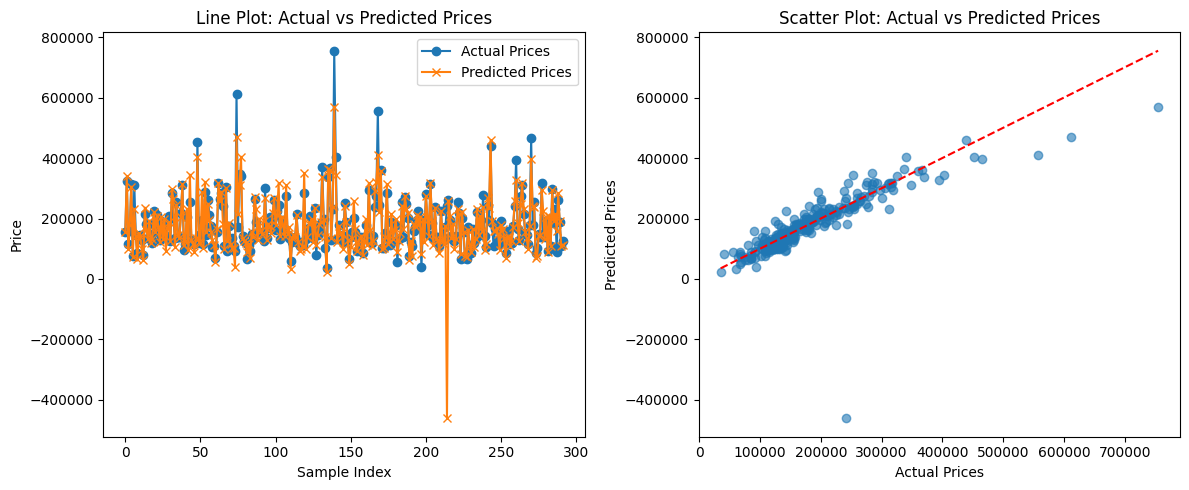

In [12]:
import matplotlib.pyplot as plt

# Predict prices
y_pred = lr_model.predict(x_val)

# Graph 1: Line plot of Actual vs Predicted Prices
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
plt.plot(y_val.values, label='Actual Prices', marker='o')
plt.plot(y_pred, label='Predicted Prices', marker='x')
plt.title('Line Plot: Actual vs Predicted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()

# Graph 2: Scatter plot of Actual vs Predicted Prices
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
plt.scatter(y_val, y_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # perfect prediction line
plt.title('Scatter Plot: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

plt.tight_layout()
plt.show()



# Model Evaluation 
To evaluate our linear regression model's performance on the validation set, we used several key metrics:

#### Root Mean Squared Error (RMSE): 
Measures the average magnitude of the prediction errors. Lower RMSE indicates better performance.

#### R² Score (Coefficient of Determination): 
Indicates how well the model explains the variability in the target variable. A higher R² value (close to 1) implies a better fit.

#### Mean Absolute Percentage Error (MAPE): 
Shows the average percentage error in predictions. It helps understand the error in relative terms.

#### Approximate Percent Accuracy: 
Derived from MAPE, it gives a rough idea of how accurate the model is overall.

#### Threshold-Based Accuracy: 
Calculates the percentage of predictions that fall within ±10% of the actual sale prices, giving insight into how often the model makes "acceptable" predictions.

These metrics collectively provide a well-rounded view of model performance in both absolute and relative terms.

In [14]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = lr_model.predict(x_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)  # manually take square root for RMSE
r2 = r2_score(y_val, y_pred)

print(f"Validation RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
percent_accuracy = 100 - mape

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Approximate Percent Accuracy: {percent_accuracy:.2f}%")

threshold = 0.10  # 10%
within_threshold = np.abs(y_val - y_pred) <= (threshold * y_val)
accuracy = np.mean(within_threshold) * 100

print(f"Percentage of predictions within ±{threshold*100}% of actual values: {accuracy:.2f}%")




Validation RMSE: 50615.33
R² Score: 0.6660
Mean Absolute Percentage Error (MAPE): 12.77%
Approximate Percent Accuracy: 87.23%
Percentage of predictions within ±10.0% of actual values: 56.16%
